## 豆瓣电影聚类分析

### 作业要求：（单人组）
##### Task1：数据预处理和特征向量化。在这个任务中，我们需要对原始数据进行预处理，将文本数据转换为特征向量。

需要完成：
- 读取数据：从给定的数据文件(movies.xls)中读取电影数据。（代码已给出）
- 清洗数据：处理缺失值、异常值等，对“简介”中的中文数据进行分词，英文数据进行清洗。
- 使用TF-IDF对“类型”和“标签”进行向量化：将文本类型和标签数据转换为数值特征向量，并用PCA降维
- 使用Word2Vec对分词后的“简介”进行向量化：将电影简介数据转换为数值特征向量。

##### Task2：特征融合和降维。在这个任务中，我们需要将不同的特征融合在一起，并使用PCA降维。

需要完成：
- 归一化数值特征：对数值特征进行归一化处理，使其在相同的取值范围内。
- 特征融合：将不同的特征向量组合成一个整体特征向量（可认为是每个电影的Embedding向量）。（建议特征包含：TF-IDF结果、WV结果、电影年份、豆瓣评分，使用np拼接即可）
- PCA降维：通过主成分分析（PCA）对特征向量进行降维处理。（可设置设置累积方差贡献率阈值确定留下多少主成分）

##### Task3：K-means聚类。在这个任务中，我们需要使用K-means聚类方法对降维后的特征向量进行聚类。

需要完成：
- 肘部法确定最佳簇数量：通过计算不同簇数量下的误差平方和，确定最佳簇数量。
- 使用最佳簇数量进行K-means聚类：根据最佳簇数量，对降维后的特征向量进行聚类。
- 分析聚类结果：输出每个簇的代表电影、簇中电影的数量、评分分布等，也可对结果进行可视化展示。


##### Task4：基于电影的 Embedding向量和表中其他信息，为导演和演员生成 Embedding，并进行无监督分类。然后使用可视化的方法，分析2-3个属于不同类别导演的特点

需要完成：
- 计算导演和演员的 Embedding
- 对导演、演员分别进行无监督分类（最好不要用K-means，可以尝试层次聚类、DBSCAN、GMM等方法）
- 分析聚类结果：输出每个类的代表人物、每个类的人数、导演电影数分布等，也可对结果进行可视化展示。
- 使用可视化的方法，分析2-3个属于不同类型的导演、与2-3个属于不同类型的演员的特点

**注意：**
- 为了使结果可复现，请尽量在所有需要随机性的地方都设置随机数种子。若实在无法稳定复现，则应当保留好所有输出。
- 可以根据自己的理解，在task1-3中使用要求之外的数据项，鼓励在过程中多进行可视化。可以在任何地方添加新的ipynb cell



In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec
import seaborn as sns
import jieba
import re
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
data = pd.read_excel('./data/movies.xls')

In [3]:
# 标签、类型数据split、清理
data.replace([' ',''], np.nan, inplace=True)
data.fillna('NaN', inplace=True)

# 类型和标签数据中有一些标签有简、繁、英三种表示，在此统一将繁体字和英文同义替换成对应的简体字，同时处理掉缺失数据
dict_mapping = {"": ["NaN"], "动作": ["動作", "Action"], "喜剧": ["喜劇", "Comedy"], "爱情": ["愛情", "Romance"], "儿童": ["兒童", "Kids"], \
                "纪录片": ["紀錄片", "Documentary"], "音乐": ["音樂", "Music"], "动画": ["動畫", "Animation"], "惊悚": ["驚悚", "Thriller"],\
                "剧情": ["劇情", "Adult", "Drama"], "真人秀": ["Reality-TV"], "国": ["國"], "电": ["電"], "湾": ["灣"], "韩": ["韓"]}

# 类型和标签数据按“/”符号为界进行分词即可
def clean_and_cut(text):
    for key, value in dict_mapping.items():
        # 将需要替换的单词用"|"连接，组成正则表达式
        pattern = "|".join(value)
        # 使用正则表达式将单词替换为对应的value
        text = re.sub(pattern, key, str(text))
    return re.sub('/', ' ', text)

data['GENRES'] = data['GENRES'].apply(clean_and_cut)
data['TAGS'] = data['TAGS'].apply(clean_and_cut)
print("GENRES字段分词后的结果：")
print(data["GENRES"],'\n')
print("TAGS字段分词后的结果：")
print(data["TAGS"])

GENRES字段分词后的结果：
0              剧情 爱情
1              动作 爱情
2                 剧情
3                 爱情
4              剧情 历史
            ...     
38184          惊悚 恐怖
38185          喜剧 爱情
38186       剧情 动作 犯罪
38187    悬疑 惊悚 恐怖 犯罪
38188             剧情
Name: GENRES, Length: 38189, dtype: object 

TAGS字段分词后的结果：
0              甘肃 临夏 伊斯兰 中国 2016 中国大陆 烂片 宣传伊斯兰教的电影
1                                            穿越 华语
2                                                 
3                   小波 王小波 爱情 小说改编 文学改编 剧情 中国 2017
4                                                 
                           ...                    
38184           血腥 恐怖 美国 惊悚 暴力 德洲电锯杀人狂前传 美国电影 2006
38185               爱情 美国 美国电影 麻雀变王妃 喜剧 浪漫喜剧 童话 电影
38186                 韩国 动作 黑帮 暴力 韩国电影 犯罪 2006 柳承完
38187    惊悚 美国 悬疑 恐怖 我看过的英语电影 我看过的电影 我看过的恐怖电影 美国电影
38188            法国 法国电影 冒险 旅行探索 动物 俄罗斯 2006 Serko
Name: TAGS, Length: 38189, dtype: object


In [4]:
# 使用TF-IDF对“类型”和“标签”进行向量化

# 对类型（GENRES）字段，将全部的35个词作为词表
tfidf_GENRES = TfidfVectorizer()
weight_GENRES = tfidf_GENRES.fit_transform(data['GENRES']).toarray()
word_GENRES = tfidf_GENRES.get_feature_names()

# 对标签（TAGS）字段，由于分词后不同的词太多，只取出现频率最高的前500个词作为词表
tfidf_TAGS = TfidfVectorizer(max_features = 500)
weight_TAGS = tfidf_TAGS.fit_transform(data['TAGS']).toarray()
word_TAGS = tfidf_TAGS.get_feature_names()

print("GENRES字段tf-idf矩阵的大小：")
print(weight_GENRES.shape,'\n')
print("TAGS字段tf-idf矩阵的大小：")
print(weight_TAGS.shape,'\n')

# 输出GENRES和TAGS的词表
vocab1 = tfidf_GENRES.vocabulary_.items()
vocab1 = sorted(vocab1, key=lambda x: x[1])
vocab2 = tfidf_TAGS.vocabulary_.items()
vocab2 = sorted(vocab2, key=lambda x: x[1])

print("GENRES字段的词表（35词）：")
print(vocab1,'\n')
print("TAGS字段的词表（500词）：")
print(vocab2)

GENRES字段tf-idf矩阵的大小：
(38189, 35) 

TAGS字段tf-idf矩阵的大小：
(38189, 500) 

GENRES字段的词表（35词）：
[('news', 0), ('传记', 1), ('儿童', 2), ('冒险', 3), ('剧情', 4), ('动作', 5), ('动画', 6), ('历史', 7), ('古装', 8), ('同性', 9), ('喜剧', 10), ('奇幻', 11), ('家庭', 12), ('恐怖', 13), ('悬疑', 14), ('情色', 15), ('惊悚', 16), ('戏曲', 17), ('战争', 18), ('歌舞', 19), ('武侠', 20), ('灾难', 21), ('爱情', 22), ('犯罪', 23), ('真人秀', 24), ('短片', 25), ('科幻', 26), ('纪录片', 27), ('脱口秀', 28), ('舞台艺术', 29), ('西部', 30), ('运动', 31), ('音乐', 32), ('鬼怪', 33), ('黑色电影', 34)] 

TAGS字段的词表（500词）：
[('1080p', 0), ('11', 1), ('12', 2), ('123', 3), ('2000s', 4), ('2006', 5), ('2007', 6), ('2008', 7), ('2009', 8), ('2010', 9), ('2010s', 10), ('2011', 11), ('2012', 12), ('2013', 13), ('2014', 14), ('2015', 15), ('2016', 16), ('2017', 17), ('2018', 18), ('2019', 19), ('2020', 20), ('3d', 21), ('3m稀影基地', 22), ('3m稀影基地论坛', 23), ('anime', 24), ('asfun', 25), ('bbc', 26), ('biff', 27), ('bl', 28), ('brigadiergeneral', 29), ('b级片', 30), ('c6', 31), ('cctv6', 32), ('china', 

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [5]:
# 使用TruncatedSVD对向量化后的数据进行降维（用时较久，约2分钟，初始化TruncatedSVD时设置random_state参数）
svd_GENRES = TruncatedSVD(n_components=20, random_state=100)
svd_RESULT_GENRES = svd_GENRES.fit_transform(weight_GENRES)
svd_TAGS = TruncatedSVD(n_components=30, random_state=100)
svd_RESULT_TAGS = svd_TAGS.fit_transform(weight_TAGS)
print(svd_RESULT_GENRES.shape)
print(svd_RESULT_TAGS.shape)

(38189, 20)
(38189, 30)


In [6]:
# 电影简介文本数据清洗，中文数据分词

# 英文分词
def text_clean(text):
    # 去除标点符号和数字、转为小写、去除多余空格
    text = re.sub('[^a-zA-Z0-9\']', ' ', text)
    text = text.lower()
    text = re.sub('\s+', ' ', text).strip()
    return text

# 中文分词
def chinese_word_cut(text):
    # 使用jieba进行中文分词，去掉特殊符号，分词后长度>=2
    useless_str = '''！“”， 。？、；’"',.、·《》()（）#\t：\n'''
    for s in useless_str:
        text = text.replace(s, '')
    word_list = jieba.cut(text)
    return ' '.join([word for word in word_list if len(word) > 1])

# 对中/英文STORYLINE分别进行处理
for i in range(len(data)):
    storyline = str(data.loc[i, 'STORYLINE'])
    data.loc[i, 'STORYLINE'] = chinese_word_cut(storyline) if re.search('[\u4e00-\u9fa5]', storyline) else text_clean(storyline)
    
print("STORYLINE字段分词后的结果：")
print(data['STORYLINE'])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Xuyifeng\AppData\Local\Temp\jieba.cache
Loading model cost 0.296 seconds.
Prefix dict has been built successfully.


STORYLINE字段分词后的结果：
0        电影 情定 夏天 使然 讲述 临夏 新一代 青年人 发奋图强 借助 国家 一带 一路 战略 ...
1        桀骜不驯 如龙 武功 高强 一场 比赛 打成 重伤 被诊 今生 不能 再用 功夫 女友 荆兰...
2        平民 女孩 李莉 只身 初入 曼哈顿 求学 历经 迷失 困惑 之后 凭借 努力 善良 收获 ...
3        王小波 经典 中篇小说 绿毛 水怪 改编 电影 绿毛 水怪 王小波 早期 手稿 作品 天马行...
4        1932 上海 虹口 爆炸案 韩国 国父 金九在 褚辅成 朱爱宝 这些 普通群众 帮助 逃到...
                               ...                        
38184    德州 屠宰场 肥胖 女工 正在 案板 切肉 突然 感到 腹中 剧痛 原来 怀有孕 羊水 破产...
38185    皇家 婚禮 2003 浪漫 喜劇片 麻雀 王妃 續集 集中 姬愛上 愛得華 不知 如假 包換...
38186    首尔 重案 刑警 郑泰秀 郑斗洪饰 接到 好友 吴汪才 死讯 于是 赶回 十年 未曾 亲近 ...
38187    a pair of siamese twins are separated and one ...
38188    1889 为了 修建 欧亚 铁路 沙皇 属下 四处 征用 马匹 期间 阿穆尔河 大公 为了 ...
Name: STORYLINE, Length: 38189, dtype: object


In [7]:
#电影简介文本数据向量化(Word2Vec，初始化Word2Vec时设置seed参数)

# 处理分词后的STORYLINE数据，转换为Word2Vec需要的格式
sentences = []
for i in range(len(data['STORYLINE'])):
    sentences.append(data['STORYLINE'][i].split())
    
# 初始化Word2Vec，向量长度设定为50，最小出现次数设定为10
model = Word2Vec(sentences=sentences, vector_size=50, window=5, min_count=10, workers=1, seed=0)
print("STORYLINE分词后符合要求的总词数：")
print(len(model.wv.index_to_key))

# 词向量累加得到STORYLINE文本的特征向量
vectors = []
for sentence in sentences:
    vector = np.zeros(50)
    count = 0
    for word in sentence:
        try:
            vector += model.wv[word]
            count += 1
        except:
            continue
    if count != 0:
        vectors.append(vector / count)
    else:
        vectors.append(vector)

print("STORYLINE特征向量矩阵的大小：")
print(np.array(vectors).shape)

STORYLINE分词后符合要求的总词数：
18069
STORYLINE特征向量矩阵的大小：
(38189, 50)


In [8]:
# 归一化数值特征
def min_max_normalize(x):
    x_min = np.min(x, axis=0, keepdims=True)
    x_max = np.max(x, axis=0, keepdims=True)
    x_normalized = (x - x_min) / (x_max - x_min)
    return x_normalized

#拼接（GENRES和TAGS的tfidf、word2vec后的STORYLINE向量、年份、豆瓣评分）
embedding = np.hstack((svd_RESULT_GENRES, svd_RESULT_TAGS, np.array(vectors), np.array(data['YEAR']).reshape(-1,1) \
                       , np.array(data['DOUBAN_SCORE']).reshape(-1, 1)))

# 对每个特征向量按列进行归一化到[0,1]范围内
embedding_normalized = min_max_normalize(embedding)

print("embedding特征向量矩阵的大小（20+30+50+1+1=102）：")
print(embedding_normalized.shape)
print(embedding_normalized)

embedding特征向量矩阵的大小（20+30+50+1+1=102）：
(38189, 102)
[[0.68146262 0.22588815 0.58672533 ... 0.31057845 1.         0.        ]
 [0.19046718 0.40606404 0.62185005 ... 0.33417499 1.         0.        ]
 [1.         0.         0.24716498 ... 0.30330391 1.         0.        ]
 ...
 [0.46560299 0.25821645 0.3307297  ... 0.33038816 0.         0.64583333]
 [0.15403278 0.74168893 0.11691698 ... 0.67251695 0.         0.5625    ]
 [1.         0.         0.24716498 ... 0.28451299 0.         0.70833333]]


In [9]:
# 特征融合(使用np进行拼接即可)
# 在上一个cell中已经完成

In [10]:
# PCA降维（可设置设置累积方差贡献率阈值确定留下多少主成分）提示：可将n_components参数设置为None，计算出所有主成分，然后根据累积方差贡献率阈值确定留下多少主成分

# 计算累计方差贡献率
def get_cumulative_variance_ratio(pca):
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    return cumulative_variance_ratio

# PCA设定保留85%以上的主成分
pca = PCA(n_components=0.85, random_state=0)
embedding_pca = pca.fit_transform(embedding_normalized)

print("降维后的embedding特征向量矩阵的大小（降成了26维）：")
print(embedding_pca.shape,'\n')

print("累计方差贡献率：")
print(get_cumulative_variance_ratio(pca)[embedding_pca.shape[1] - 1])

print(embedding_pca[0])

降维后的embedding特征向量矩阵的大小（降成了26维）：
(38189, 26) 

累计方差贡献率：
0.8536374935677794
[-0.32729021  0.19015285  0.23507597  0.55433604 -0.08058511 -0.06243189
  0.22775604 -0.09971313  0.48759476 -0.05534874 -0.07428817 -0.05183207
  0.11256395 -0.08926147 -0.03695194  0.08870449  0.0626817  -0.20113729
 -0.12092923  0.1055947  -0.01829856  0.17914827  0.51315652 -0.1935065
 -0.1313017   0.34209661]


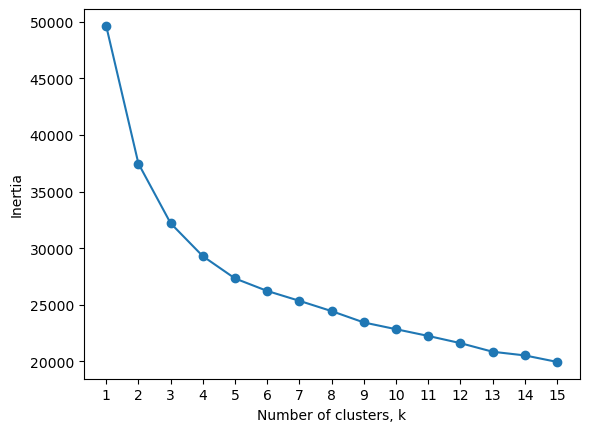

In [11]:
# 肘部法确定最佳簇数量并进行聚类，可进行cluster-inertia可视化。使用KMeans时设置random_state参数。提示：kmeans实例有inertia_变量可用于获取聚类的簇内误差平方和

# 肘部法函数，获取不同簇数量下的误差平方和
def get_cluster_inertia(embedding, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=100)
    kmeans.fit(embedding)
    return kmeans.inertia_

# cluster-inertia可视化
ks = range(1, 16)
inertias = []
for k in ks:
    inertias.append(get_cluster_inertia(embedding_pca, k))
    
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

In [12]:
# 使用KMeans进行聚类，按上图k=4,5时为肘部，最终根据实际情况选择聚成7类
kmeans = KMeans(n_clusters=7, random_state=0)
kmeans.fit(embedding_pca)
labels = kmeans.labels_

print("聚类结果（查看前100部电影的分类标签）：")
print(labels[:100])

聚类结果（查看前100部电影的分类标签）：
[3 3 0 3 3 3 3 3 3 3 3 3 5 3 3 1 3 3 3 5 3 0 0 3 3 2 3 2 2 3 2 5 3 3 3 5 3
 3 3 3 1 5 1 3 3 3 1 3 3 3 3 3 0 2 3 1 3 3 2 1 3 3 3 3 0 3 3 2 3 1 0 3 3 3
 1 3 2 5 3 1 3 3 3 2 1 3 3 3 3 3 1 3 3 3 3 6 2 2 3 1]


---------------------------------------DIVIDER---------------------------------------
Cluster 0 :
纯粹的剧情片，设定都是基于现实世界的，内容平实、没有架空元素，这类电影质量相对较高 

代表电影及其标签：
漂洋过海来爱你 剧情 

观看人数最多的前10部电影：
           NAME GENRES  DOUBAN_VOTES  DOUBAN_SCORE
19282   小森林 夏秋篇     剧情        231551           9.0
20421      十二公民     剧情        208473           8.3
15812   小森林 冬春篇     剧情        200877           9.0
21485      百鸟朝凤     剧情        168071           8.1
5004        过春天     剧情        139716           7.7
37514     追风筝的人     剧情        119346           8.2
29394      海洋天堂     剧情        112413           7.9
31845      成长教育     剧情        105483           7.7
28008  再见我们的幼儿园     剧情        101162           8.7
34135        七磅     剧情        100276           8.1 

簇中电影的数量: 5394 

豆瓣评分分布情况:


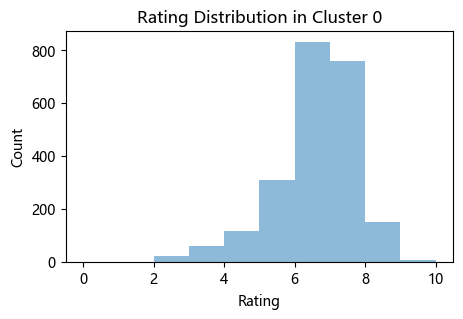

评分平均值（忽略0分电影）: 6.57
评分标准差（忽略0分电影）: 1.13
Top 3 Movies:
  1. 红色 (9.3)
  2. 谁害怕弗吉尼亚·伍尔芙？ (9.1)
  3. 小森林 冬春篇 (9.0)

GENRES电影类型分布情况:


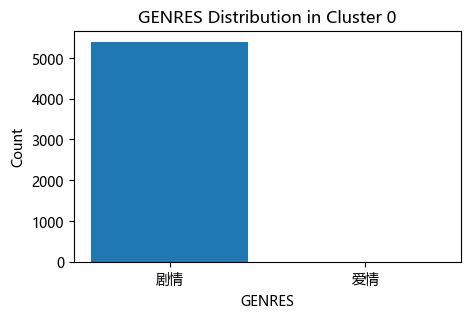

---------------------------------------DIVIDER---------------------------------------
Cluster 1 :
类别比较杂，以剧情、喜剧、动作为主，大部分为娱乐商业片，可以认为是没什么思考量的'爽片' 

代表电影及其标签：
Paul Chowdhry: What's Happening White People? 喜剧 脱口秀 

观看人数最多的前10部电影：
              NAME          GENRES  DOUBAN_VOTES  DOUBAN_SCORE
29744     狄仁杰之通天帝国        动作 悬疑 古装        199365           6.5
29035       魔法师的学徒  剧情 喜剧 动作 奇幻 冒险         53981           6.1
34921          东京！        剧情 喜剧 奇幻         13264           7.8
31287      李小龙我的兄弟     剧情 动作 爱情 传记          7481           6.3
34762         郎在远方           爱情 战争          1654           7.4
23790         侯门之险           剧情 悬疑          1237           5.6
21186        迷人的保姆           爱情 情色          1132           3.2
13587        扯蛋圣诞史              喜剧          1083           8.1
23539  西蒙·阿姆斯特尔：麻木          喜剧 脱口秀           952           9.3
23805        无条件的爱        剧情 惊悚 同性           946           6.7 

簇中电影的数量: 5251 

豆瓣评分分布情况:


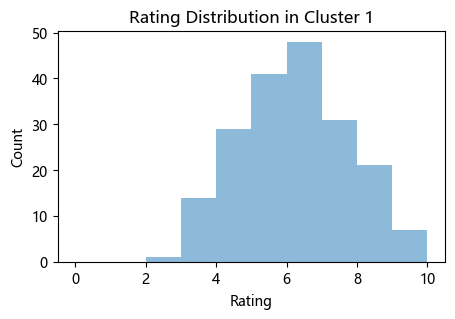

评分平均值（忽略0分电影）: 6.19
评分标准差（忽略0分电影）: 1.54
Top 3 Movies:
  1. 黄子华栋笃笑之金盘𠺘口 (9.4)
  2. 杀手乐团：皇家艾伯特音乐厅演唱会 (9.4)
  3. 迪兰·莫兰：脱身 (9.3)

GENRES电影类型分布情况:


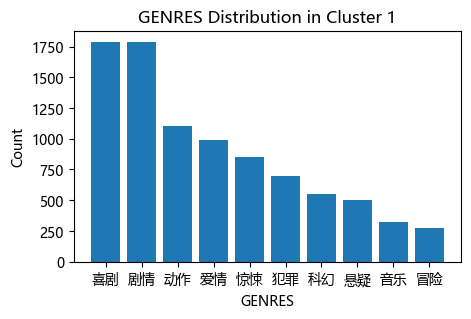

---------------------------------------DIVIDER---------------------------------------
Cluster 2 :
外国电影，这一类电影内容基本上都与西方的历史/文化/艺术有关，国内观众可能对此不太感冒，所以在豆瓣平台上明显观影人数少 

代表电影及其标签：
偷心加油站 剧情 西部 

观看人数最多的前10部电影：
                     NAME       GENRES  DOUBAN_VOTES  DOUBAN_SCORE
13879           极品基老伴：完结篇        喜剧 同性         17474           9.3
30898           神秘博士：圣诞颂歌     科幻 奇幻 冒险          4315           8.6
28306                 铁甲衣        动作 冒险          3394           6.6
31094          蒂塔·万·提斯疯马秀           歌舞          3097           8.4
32630                茜茜公主  剧情 爱情 历史 战争          3048           8.4
34575            爱因斯坦与爱丁顿     剧情 传记 历史          3023           7.7
14179              亡命徒与天使     剧情 犯罪 西部          2973           7.5
20109          神秘博士：最后的圣诞        剧情 科幻          2798           8.4
30021            性、毒品和摇滚乐     剧情 音乐 传记          2424           7.4
13395  乐高DC超级英雄：正义联盟之宇宙冲击        动作 动画          2272           7.5 

簇中电影的数量: 6958 

豆瓣评分分布情况:


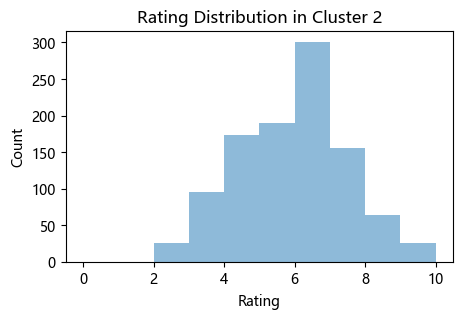

评分平均值（忽略0分电影）: 5.90
评分标准差（忽略0分电影）: 1.52
Top 3 Movies:
  1. Coldplay -  Ghost Stories Live 2014 (9.5)
  2. 跳出我天地音乐剧 (9.4)
  3. 五位(还嫌少)博士重启 (9.4)

GENRES电影类型分布情况:


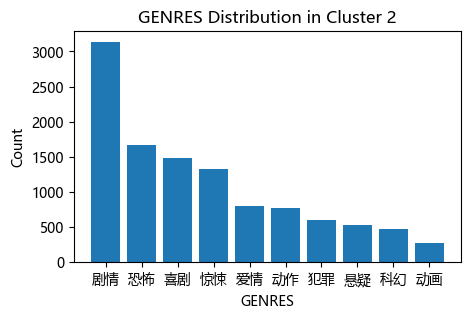

---------------------------------------DIVIDER---------------------------------------
Cluster 3 :
烂片，豆瓣评分集中在2-4分之间 

代表电影及其标签：
我未成年 剧情 儿童 

观看人数最多的前10部电影：
             NAME             GENRES  DOUBAN_VOTES  DOUBAN_SCORE
22937    天机·富春山居图              动作 冒险         98654           2.9
15964  纯洁心灵·逐梦演艺圈              剧情 喜剧         84842           2.2
6034         欧洲攻略           喜剧 动作 爱情         52218           3.5
13968        封神传奇           剧情 动作 奇幻         50268           2.9
25361         血滴子           动作 武侠 古装         49288           4.6
28447          战国  剧情 动作 爱情 悬疑 战争 古装         35299           3.9
20624        大话天仙           喜剧 奇幻 古装         27247           3.1
17915         放手爱              喜剧 爱情         24965           2.3
6616         武林怪兽           喜剧 奇幻 武侠         21835           3.5
1549       下一任：前任                 爱情         20398           2.8 

簇中电影的数量: 7510 

豆瓣评分分布情况:


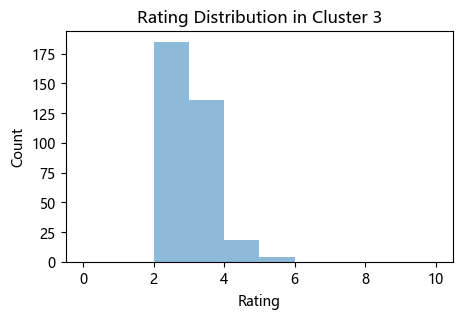

评分平均值（忽略0分电影）: 3.00
评分标准差（忽略0分电影）: 0.56
Top 3 Movies:
  1. 非你莫属 (5.3)
  2. 泊车殿下 (5.1)
  3. 一吻定情电影版3：求婚篇 (5.0)

GENRES电影类型分布情况:


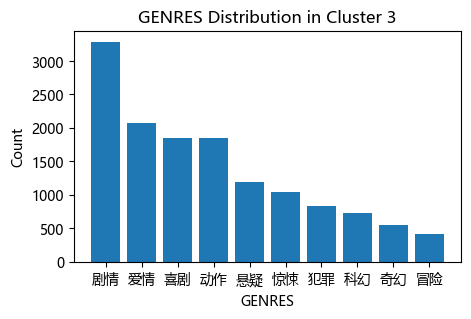

---------------------------------------DIVIDER---------------------------------------
Cluster 4 :
人气电影，观影人数明显比其他类多，整体上评分也相对稍好一些 

代表电影及其标签：
周六夜现场 剧情 喜剧 舞台艺术 

观看人数最多的前10部电影：
               NAME       GENRES  DOUBAN_VOTES  DOUBAN_SCORE
3498        哪吒之魔童降世  剧情 喜剧 动画 奇幻        889431           8.6
12661        摔跤吧！爸爸  剧情 家庭 传记 运动        870905           9.0
6273           头号玩家     动作 科幻 冒险        841114           8.7
32201         飞屋环游记  剧情 喜剧 动画 冒险        789525           9.0
13969         你的名字。     剧情 爱情 动画        775533           8.4
6203           无名之辈        剧情 喜剧        699120           8.1
4607           一出好戏        剧情 喜剧        665824           7.1
26268  那些年，我们一起追的女孩     剧情 喜剧 爱情        653722           8.1
13868        看不见的客人  剧情 悬疑 惊悚 犯罪        650397           8.8
6646             无双  剧情 动作 悬疑 犯罪        647077           8.1 

簇中电影的数量: 7805 

豆瓣评分分布情况:


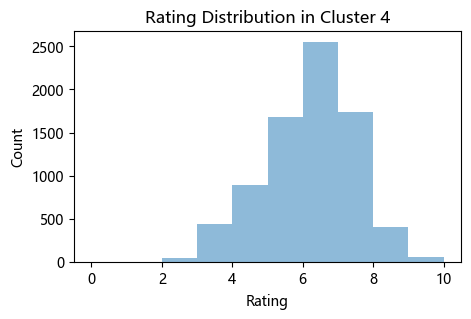

评分平均值（忽略0分电影）: 6.17
评分标准差（忽略0分电影）: 1.26
Top 3 Movies:
  1. 悲惨世界：25周年纪念演唱会 (9.6)
  2. 神秘博士：DT的视频日志：最后的日子 (9.6)
  3. 第十二夜 (9.5)

GENRES电影类型分布情况:


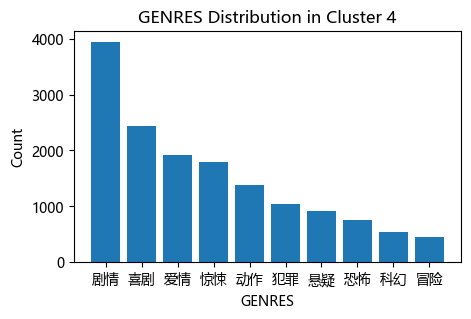

---------------------------------------DIVIDER---------------------------------------
Cluster 5 :
动画/动漫电影，这类电影整体上评分较高，说明动画类电影的好片占比较高 

代表电影及其标签：
潜艇总动员3：彩虹宝藏 动画 儿童 

观看人数最多的前10部电影：
            NAME    GENRES  DOUBAN_VOTES  DOUBAN_SCORE
30921       驯龙高手  动画 奇幻 冒险        446545           8.7
36470      秒速5厘米  剧情 爱情 动画        419194           8.3
32273     玛丽和马克思  剧情 喜剧 动画        293141           8.9
34408    悬崖上的金鱼姬  动画 奇幻 冒险        265528           8.4
21393       怪兽大学  喜剧 动画 冒险        248447           8.1
16654        小王子     动画 奇幻        200509           8.1
19055  哆啦A梦：伴我同行     剧情 动画        199372           8.0
2960         狮子王  剧情 动画 冒险        190326           7.4
22459       言叶之庭     爱情 动画        187584           8.2
17666     小黄人大眼萌     喜剧 动画        185214           7.5 

簇中电影的数量: 2058 

豆瓣评分分布情况:


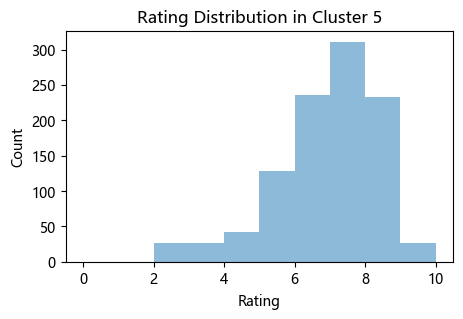

评分平均值（忽略0分电影）: 6.92
评分标准差（忽略0分电影）: 1.45
Top 3 Movies:
  1. 夏目友人帐 第六季 特别篇 铃响的残株 (9.6)
  2. 夏目友人帐 五 特别篇：一夜酒杯 (9.5)
  3. 狐妖小红娘剧场版：月红篇 (9.3)

GENRES电影类型分布情况:


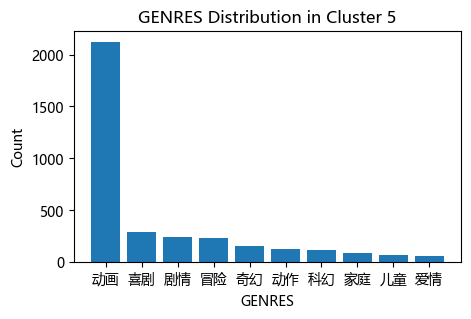

---------------------------------------DIVIDER---------------------------------------
Cluster 6 :
恐怖电影，这类电影整体上评分较低，说明恐怖片里面的烂片占比较高 

代表电影及其标签：
本当の心霊動画 影 6 恐怖 

观看人数最多的前10部电影：
             NAME GENRES  DOUBAN_VOTES  DOUBAN_SCORE
3682          昆池岩     恐怖        119497           6.1
8126          妖铃铃  喜剧 恐怖        102311           4.2
14164        无名女尸     恐怖         65731           7.5
31629      咒怨：白老妇     恐怖         13462           5.8
28449       人皮客栈3     恐怖         12397           5.5
28114  致命弯道4：血腥起源     恐怖         10940           5.4
24104        贞子3D     恐怖          8744           3.7
23541     切尔诺贝利日记     恐怖          8372           5.6
15730  残秽，不可以住的房间     恐怖          7944           6.8
33063       黑色星期五     恐怖          7462           5.8 

簇中电影的数量: 3213 

豆瓣评分分布情况:


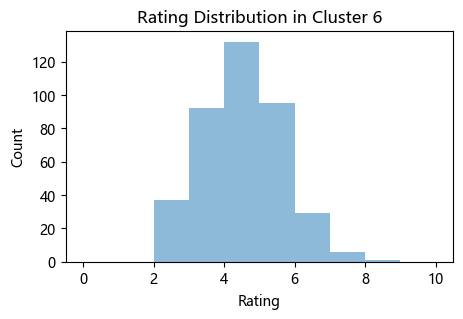

评分平均值（忽略0分电影）: 4.48
评分标准差（忽略0分电影）: 1.11
Top 3 Movies:
  1. 疯城记：万圣节特辑 (8.7)
  2. 无名女尸 (7.5)
  3. 鸡皮疙瘩NO.3 (7.4)

GENRES电影类型分布情况:


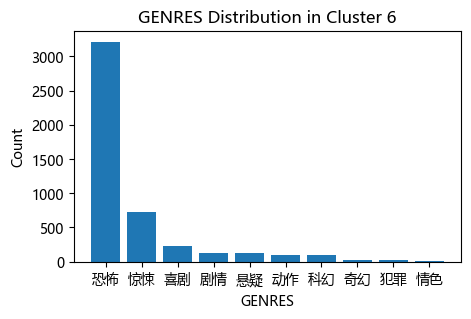

---------------------------------------DIVIDER---------------------------------------


In [13]:
# 打印每个簇的信息、可视化等
import matplotlib
matplotlib.rc("font", family='Microsoft YaHei')

# 获取每个簇的代表电影
cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_
representative_movies = []
for i in range(kmeans.n_clusters):
    cluster_i_indices = (cluster_labels == i)
    cluster_i_embeddings = embedding_pca[cluster_i_indices]
    # 计算每个电影到聚类中心的距离
    distances = []
    for j in range(len(cluster_i_embeddings)):
        distance = np.linalg.norm(cluster_i_embeddings[j] - cluster_centers[i])
        distances.append(distance)
    # 找到距离聚类中心最近的电影，作为代表电影
    representative_movie_index = np.argmin(distances)
    representative_movie = data[cluster_i_indices].iloc[representative_movie_index]
    representative_movies.append(representative_movie)
representative_movies_df = pd.DataFrame(representative_movies)
centroids = np.array(representative_movies_df.index)

# 获取每个簇中观看人数最多的前10部电影
top_movies_df_list = []
for i in range(kmeans.n_clusters):
    # 获取该簇的索引值
    cluster_i_indices = (cluster_labels == i)
    # 获取该簇的电影
    cluster_i_movies = data[cluster_i_indices]
    # 对该簇的电影按照观看人数进行排序，取前10位
    sorted_cluster_i_movies = cluster_i_movies.sort_values('DOUBAN_VOTES', ascending=False)
    top_cluster_i_movies = sorted_cluster_i_movies.head(10)
    top_movies_df_list.append(top_cluster_i_movies)
top_movies_df = pd.concat(top_movies_df_list)

# 获取簇中电影的数量
cluster_movie_counts = {}
for label in cluster_labels:
    if label in cluster_movie_counts:
        cluster_movie_counts[label] += 1
    else:
        cluster_movie_counts[label] = 1

# 对每类电影内容的解读：
content = {0: "纯粹的剧情片，设定都是基于现实世界的，内容平实、没有架空元素，这类电影质量相对较高", \
           1: "类别比较杂，以剧情、喜剧、动作为主，大部分为娱乐商业片，可以认为是没什么思考量的'爽片'", \
           2: "外国电影，这一类电影内容基本上都与西方的历史/文化/艺术有关，国内观众可能对此不太感冒，所以在豆瓣平台上明显观影人数少", \
           3: "烂片，豆瓣评分集中在2-4分之间", \
           4: "人气电影，观影人数明显比其他类多，整体上评分也相对稍好一些", \
           5: "动画/动漫电影，这类电影整体上评分较高，说明动画类电影的好片占比较高", \
           6: "恐怖电影，这类电影整体上评分较低，说明恐怖片里面的烂片占比较高", }
mean_score, std_score = [0 for i in range(kmeans.n_clusters)], [0 for i in range(kmeans.n_clusters)]
# 依次输出每一类电影的信息
print('---------------------------------------DIVIDER---------------------------------------')
for i in range(kmeans.n_clusters):
    print('Cluster',i,':')
    print(content[i], "\n")
    print("代表电影及其标签：")
    print(data.iloc[centroids[i]]["NAME"], data.iloc[centroids[i]]["GENRES"],'\n')
    
    print("观看人数最多的前10部电影：")
    print(top_movies_df_list[i][['NAME', 'GENRES', 'DOUBAN_VOTES', 'DOUBAN_SCORE']],'\n')
    
    print("簇中电影的数量:",cluster_movie_counts[i],'\n')
    
    print("豆瓣评分分布情况:")
    
    # 统计每个簇中电影的评分分布，并可视化
    ratings = [float(data.iloc[j]["DOUBAN_SCORE"]) for j in range(len(cluster_labels)) if cluster_labels[j] == i and float(data.iloc[j]["DOUBAN_SCORE"]) > 0]
    plt.figure(figsize=(5, 3))
    plt.hist(ratings, bins=10, range=(0, 10), alpha=0.5)
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.title('Rating Distribution in Cluster {}'.format(i))
    plt.show()
    
    # 统计每个簇中电影的评分平均值和标准差
    mean_score[i] = np.mean(ratings)
    std_score[i] = np.std(ratings)
    print('评分平均值（忽略0分电影）: {:.2f}'.format(mean_score[i]))
    print('评分标准差（忽略0分电影）: {:.2f}'.format(std_score[i]))
    
    # 统计每个簇中评分最高的三部电影
    ratings2 = [(data.iloc[j]["DOUBAN_SCORE"], data.iloc[j]["NAME"]) for j in range(len(cluster_labels)) if cluster_labels[j] == i and float(data.iloc[j]["DOUBAN_SCORE"]) > 0]
    sorted_ratings = sorted(ratings2, key=lambda t: t[0], reverse=True)
    print('Top 3 Movies:')
    for j in range(3):
        print('  {}. {} ({})'.format(j + 1, sorted_ratings[j][1], sorted_ratings[j][0]))
    
    print("\nGENRES电影类型分布情况:")
    
    # 统计每个簇内各个GENRES词的出现次数
    genres_count = {}
    for j in range(len(cluster_labels)):
        if cluster_labels[j] == i:
            genres = data.iloc[j]['GENRES'].split(' ')
            for genre in genres:
                if genre in genres_count:
                    genres_count[genre] += 1
                else:
                    genres_count[genre] = 1
    
    # 对每个簇的GENRES类别按照出现次数从高到低排序，取出前10个GENRES类
    top_genres = []
    sorted_genres = sorted(genres_count.items(), key=lambda x: x[1], reverse=True)
    top_genres = [x[0] for x in sorted_genres[:10]]
    
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.bar(top_genres, [genres_count[genre] for genre in top_genres])
    ax.set_title('GENRES Distribution in Cluster {}'.format(i))
    ax.set_xlabel('GENRES')
    ax.set_ylabel('Count')
    plt.show()

    print('---------------------------------------DIVIDER---------------------------------------')

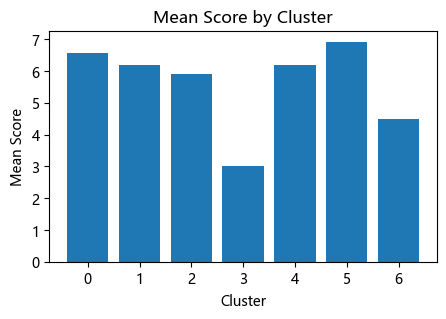

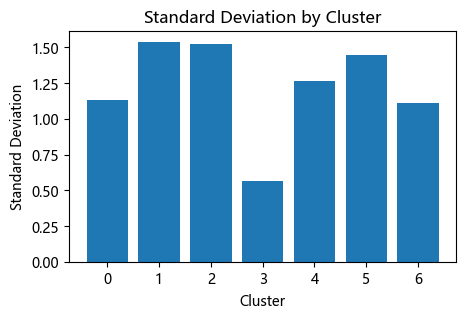

In [14]:
# 再横向对比一下每类电影的评分均值和标准差

k = kmeans.n_clusters
# 均值
fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(range(k), mean_score)
ax.set_xlabel('Cluster')
ax.set_ylabel('Mean Score')
ax.set_title('Mean Score by Cluster')
plt.show()

# 标准差
fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(range(k), std_score)
ax.set_xlabel('Cluster')
ax.set_ylabel('Standard Deviation')
ax.set_title('Standard Deviation by Cluster')
plt.show()


In [15]:
# Task 4:自由发挥

# 查看演员和导演数据，每个人之间用“/”字符分隔
actor = data['ACTORS'].apply(lambda x: re.sub('[^\u4e00-\u9fa5a-zA-Z|·/]', '', x))
director = data['DIRECTORS'].apply(lambda x: re.sub('[^\u4e00-\u9fa5a-zA-Z|·/]', '', x))
print(actor)
print(director)

0          王博/吴佳尼/王姬/高丽雯/郭力行/尹哲/沈丹萍/罗中旭/臧金生/罗刚/居文沛/阎青妤
1                                      谷尚蔚/吴孟达/曾志伟/杜海涛
2                                                  NaN
3                                                  NaN
4                                                  NaN
                             ...                      
38184    乔丹娜·布鲁斯特/安德鲁·布莱尼亚斯基/迪奥拉·拜尔德/泰勒·汉德雷/李·厄米/马特·波莫
38185                             卢克·梅伯利/乔纳森·佛斯/玛瑞·亚达波
38186              安在模/郑斗洪/金秉玉/金花雨/金瑞亨/金时厚/李凡秀/温宙完/柳昇完
38187                      露·杜瓦隆/斯蒂芬·瑞/威廉·B·戴维斯/科洛·塞维尼
38188                                  阿雷克西·查多夫/雅克·冈布兰
Name: ACTORS, Length: 38189, dtype: object
0              尹哲
1             洪金宝
2             NaN
3          梁栋/吴国墉
4             NaN
           ...   
38184    乔纳森·里贝斯曼
38185         NaN
38186         柳昇完
38187      道格拉斯巴克
38188         NaN
Name: DIRECTORS, Length: 38189, dtype: object


In [16]:
# 对导演和演员，分别统计字典，用 演员名:[所出演的电影编号的列表] 这样的形式统计每一位演员出演过的所有电影。对导演同理。

actor_dict = {}
director_dict = {}
for i in range(len(data)):
    actors = str(actor[i]).split('/')  # 将演员信息按照“/”分隔成列表
    directors = str(director[i]).split('/')  # 将导演信息按照“/”分隔成列表
    # 统计演员信息
    for actor_name in actors:
        if actor_name != 'NaN':  # 忽略空白数据
            if actor_name in actor_dict:
                actor_dict[actor_name].append(i)
            else:
                actor_dict[actor_name] = [i]
    # 统计导演信息
    for director_name in directors:
        if director_name != 'NaN':  # 忽略空白数据
            if director_name in director_dict:
                director_dict[director_name].append(i)
            else:
                director_dict[director_name] = [i]

print("数据集中总共涉及的演员人数：")
print(len(actor_dict))
print("数据集中总共涉及的导演人数：")
print(len(director_dict),'\n')

def check_score(v):
    cnt = 0
    for movie_id in v:
        if data.iloc[movie_id]["DOUBAN_SCORE"] != 0:
            cnt += 1
    return 0 if cnt <=1 else 1
print("再进行一次筛选，只保留那些出演了8部以上电影的演员和执导了3部电影以上的导演，且电影不能全部无评分。")
actor_dict = {k: v for k, v in actor_dict.items() if len(v) >= 8 and check_score(v) != 0}
director_dict = {k: v for k, v in director_dict.items() if len(v) >= 3 and check_score(v) != 0}
print("筛选后数据集中总共涉及的演员人数：")
print(len(actor_dict))
print("筛选后数据集中总共涉及的导演人数：")
print(len(director_dict),'\n')

from itertools import islice
print("查看其中10位演员的信息（演员名:[所出演的电影编号的列表]）：")
print({k: v for k, v in islice(actor_dict.items(), 10)}, '\n')
print("查看其中10位导演的信息（导演名:[所执导的电影编号的列表]）：")
print({k: v for k, v in islice(director_dict.items(), 10)})

数据集中总共涉及的演员人数：
50663
数据集中总共涉及的导演人数：
12839 

再进行一次筛选，只保留那些出演了8部以上电影的演员和执导了3部电影以上的导演，且电影不能全部无评分。
筛选后数据集中总共涉及的演员人数：
2710
筛选后数据集中总共涉及的导演人数：
1278 

查看其中10位演员的信息（演员名:[所出演的电影编号的列表]）：
{'王博': [0, 3364, 6876, 6902, 7908, 9055, 9645, 11330, 14378, 14549, 15451, 27658, 32255], '王姬': [0, 737, 1994, 2516, 7338, 17315, 18552, 19006, 22641, 24103, 24145, 25058, 32529, 33352, 35259, 37088], '沈丹萍': [0, 6382, 15665, 18688, 19358, 25487, 28085, 31039, 31545, 33881], '吴孟达': [1, 994, 1159, 3493, 4159, 6963, 9804, 13948, 14928, 17808, 19662, 24151, 25058, 28362, 35214], '曾志伟': [1, 73, 994, 2106, 2181, 2247, 4473, 5466, 6102, 6963, 7532, 9119, 9271, 11295, 12129, 13582, 14968, 15206, 16009, 17373, 19085, 19662, 20374, 21477, 21533, 21925, 22227, 22771, 24049, 24229, 26351, 27087, 29419, 31118, 31344, 32072, 33260, 33402, 34335, 35037, 35214, 35385, 35439, 36102, 36935, 37487], '杜海涛': [1, 73, 4600, 9484, 9969, 10582, 11535, 11816, 12243, 12782, 12908, 16826, 17477, 17810, 20073, 20367, 22058, 24766, 24851, 273

In [17]:
# 计算导演和演员的embedding

actors_names = []  # 初始化演员姓名列表
directors_names = []  # 初始化导演姓名列表
# 为导演生成embedding
directors_embeddings = np.zeros((len(director_dict), embedding_pca.shape[1]))  # 初始化导演embedding矩阵
for i, (director_name, movie_ids) in enumerate(director_dict.items()):
    director_embeddings = np.zeros((len(movie_ids), embedding_pca.shape[1]))  # 初始化该导演的embedding矩阵
    for j, movie_id in enumerate(movie_ids):
        director_embeddings[j] = embedding_pca[movie_id]  # 获取该电影的embedding
    mean_embeddings = np.mean(director_embeddings, axis=0)  # 对该导演的所有电影embedding取平均值
    directors_embeddings[i] = mean_embeddings
    directors_names.append(director_name)
    
# 为演员生成embedding
actors_embeddings = np.zeros((len(actor_dict), embedding_pca.shape[1]))  # 初始化演员embedding矩阵
for i, (actor_name, movie_ids) in enumerate(actor_dict.items()):
    actor_embeddings = np.zeros((len(movie_ids), embedding_pca.shape[1]))  # 初始化该演员的embedding矩阵
    for j, movie_id in enumerate(movie_ids):
        actor_embeddings[j] = embedding_pca[movie_id]  # 获取该电影的embedding
    mean_embeddings = np.mean(actor_embeddings, axis=0)  # 对该演员的所有电影embedding取平均值
    actors_embeddings[i] = mean_embeddings
    actors_names.append(actor_name)

print("导演数据的embedding矩阵大小：", directors_embeddings.shape)
print("演员数据的embedding矩阵大小：", actors_embeddings.shape)

导演数据的embedding矩阵大小： (1278, 26)
演员数据的embedding矩阵大小： (2710, 26)


In [18]:
# 对导演、演员分别进行无监督分类（此处使用层次聚类）

from sklearn.cluster import AgglomerativeClustering
# 对导演进行层次聚类
n_clusters_directors = 5
model_directors = AgglomerativeClustering(n_clusters=n_clusters_directors, linkage='ward')
labels_directors = model_directors.fit_predict(directors_embeddings)
# 对演员进行层次聚类
n_clusters_actors = 5
model_actors = AgglomerativeClustering(n_clusters=n_clusters_actors, linkage='ward')
labels_actors = model_actors.fit_predict(actors_embeddings)

print("导演的分类结果（查看前100位导演的分类标签）：")
print(labels_directors[:100])
print("演员的分类结果（查看前100位演员的分类标签）：")
print(labels_actors[:100])

导演的分类结果（查看前100位导演的分类标签）：
[1 3 0 3 2 0 2 0 0 0 1 0 0 0 0 0 3 0 0 0 0 2 0 0 0 0 1 2 2 2 0 0 0 0 1 0 0
 0 0 1 0 2 1 0 1 0 0 0 3 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 2 3 0 1 3 0 3 1 2 2
 0 0 1 0 3 0 2 0 0 4 2 0 3 0 2 0 0 3 2 0 4 3 0 0 0 3]
演员的分类结果（查看前100位演员的分类标签）：
[4 4 4 4 4 4 1 1 1 4 4 4 4 4 4 1 4 1 1 1 4 4 1 1 1 1 1 1 1 1 4 1 1 1 1 0 1
 1 4 1 1 1 1 4 4 1 1 1 1 1 1 0 4 4 4 4 1 1 1 1 1 4 1 4 1 1 1 4 4 1 1 1 1 1
 1 4 4 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 1 1 1]


In [19]:
# 导演聚类结果（每个类的导演数、代表导演及其代表作）

cluster_movie_count = {}
def get_representative_directors(labels, embeddings):
    # 获取每一类的中心
    centers = []
    for i in range(n_clusters_directors):
        indices = np.where(labels == i)[0]
        cluster_movie_count[i] = len(indices)
        center = np.mean(embeddings[indices], axis=0)
        centers.append(center)
    centers = np.array(centers)
    # 计算到中心的距离
    distances = np.sqrt(((embeddings[:, np.newaxis, :] - centers) ** 2).sum(axis=2))
    # 找最近的导演作为代表人物
    representative_directors = np.argmin(distances, axis=0)
    return representative_directors

def get_top_directors_by_movie_count(labels):
    top_directors = {}
    for i in range(n_clusters_directors):
        indices = np.where(labels == i)[0]
        movies_count = [(directors_names[j], director_dict[directors_names[j]]) for j in indices]
        movies_count = sorted(movies_count, key=lambda t: len(t[1]), reverse=True)
        top_directors[i] = movies_count[:4]
    return top_directors

# 获取每个类别的代表导演
representative_directors = get_representative_directors(labels_directors, directors_embeddings)
representative_directors = [directors_names[i] for i in representative_directors]

# 获取每个类别执导电影数目最多的前4位导演及他们执导的电影编号
top_directors = get_top_directors_by_movie_count(labels_directors)

print('---------------------------------------DIVIDER---------------------------------------')
for i in range(n_clusters_directors):
    print('Cluster',i,':')
    print("簇内的导演数：", cluster_movie_count[i])
    print("代表导演：", representative_directors[i],'\n')
    
    print("簇中执导电影数目最多的4位导演，以及每人的三部作品：")
    for j in range(4):
        print(top_directors[i][j][0])
        movie_list = top_directors[i][j][1]
        movie_list = sorted(movie_list, key=lambda t: data.iloc[t]["DOUBAN_SCORE"], reverse=True)[:3]
        print(data.iloc[movie_list][['NAME', 'GENRES', 'DOUBAN_VOTES', 'DOUBAN_SCORE']], '\n')
    
    
    print('---------------------------------------DIVIDER---------------------------------------')

---------------------------------------DIVIDER---------------------------------------
Cluster 0 :
簇内的导演数： 516
代表导演： 刘伟强 

簇中执导电影数目最多的4位导演，以及每人的三部作品：
刘信义
              NAME          GENRES  DOUBAN_VOTES  DOUBAN_SCORE
16991  九纹龙史进之除恶史家庄           剧情 武侠           105           6.4
12541   九纹龙史进之扬威华州           剧情 动作            66           6.1
18672       顾大嫂与孙新  喜剧 爱情 冒险 武侠 古装            77           5.9 

邱礼涛
                  NAME    GENRES  DOUBAN_VOTES  DOUBAN_SCORE
35144  性工作者2：我不卖身，我卖子宫        剧情          7399           6.9
21533          叶问：终极一战  剧情 动作 传记         20348           6.2
27016           变节：潜罪犯  动作 悬疑 犯罪         27369           6.1 

王晶
       NAME GENRES  DOUBAN_VOTES  DOUBAN_SCORE
8791     追龙  动作 犯罪        235038           7.2
32598  金钱帝国     犯罪         42686           6.4
2733    长风镇     剧情           351           6.3 

钟海
        NAME GENRES  DOUBAN_VOTES  DOUBAN_SCORE
16139   巡回法官     剧情           208           7.5
27252  简单的美丽     剧情           114           7.3
313

In [20]:
# 演员聚类结果（每个类的演员数、代表演员及其代表作）

cluster_movie_count = {}
def get_representative_actors(labels, embeddings):
    # 获取每一类的中心
    centers = []
    for i in range(n_clusters_actors):
        indices = np.where(labels == i)[0]
        cluster_movie_count[i] = len(indices)
        center = np.mean(embeddings[indices], axis=0)
        centers.append(center)
    centers = np.array(centers)
    # 计算到中心的距离
    distances = np.sqrt(((embeddings[:, np.newaxis, :] - centers) ** 2).sum(axis=2))
    # 找最近的演员作为代表人物
    representative_actors = np.argmin(distances, axis=0)
    return representative_actors

def get_top_actors_by_movie_count(labels):
    top_actors = {}
    for i in range(n_clusters_actors):
        indices = np.where(labels == i)[0]
        movies_count = [(actors_names[j], actor_dict[actors_names[j]]) for j in indices]
        movies_count = sorted(movies_count, key=lambda t: len(t[1]), reverse=True)
        top_actors[i] = movies_count[:20]
    return top_actors

# 获取每个类别的代表演员
representative_actors = get_representative_actors(labels_actors, actors_embeddings)
representative_actors = [actors_names[i] for i in representative_actors]

# 获取每个类别参演电影数目最多的前4位演员及他们参演的电影编号
top_actors = get_top_actors_by_movie_count(labels_actors)

print('---------------------------------------DIVIDER---------------------------------------')
for i in range(n_clusters_actors):
    print('Cluster',i,':')
    print("簇内的演员数：", cluster_movie_count[i])
    print("代表演员：", representative_actors[i],'\n')
    
    print("簇中参演电影数目最多的4位演员，以及每人的三部作品：")
    for j in range(4):
        print(top_actors[i][j][0])
        movie_list = top_actors[i][j][1]
        movie_list = sorted(movie_list, key=lambda t: data.iloc[t]["DOUBAN_SCORE"], reverse=True)[:3]
        print(data.iloc[movie_list][['NAME', 'GENRES', 'DOUBAN_VOTES', 'DOUBAN_SCORE']], '\n')
    
    
    print('---------------------------------------DIVIDER---------------------------------------')

---------------------------------------DIVIDER---------------------------------------
Cluster 0 :
簇内的演员数： 385
代表演员： 热拉尔·德帕迪约 

簇中参演电影数目最多的4位演员，以及每人的三部作品：
埃里克·罗伯茨
        NAME          GENRES  DOUBAN_VOTES  DOUBAN_SCORE
21517  入侵华尔街           剧情 惊悚         10613           6.5
27959  惊叫大电影  喜剧 动作 科幻 恐怖 歌舞          5572           6.5
21373   拉芙蕾丝              传记          9981           6.3 

热拉尔·德帕迪约
           NAME GENRES  DOUBAN_VOTES  DOUBAN_SCORE
30156  与玛格丽特的午后     喜剧         23372           8.8
32779        源头     剧情           236           7.6
29789      微观世界     剧情           152           7.5 

汤姆·塞兹摩尔
                   NAME          GENRES  DOUBAN_VOTES  DOUBAN_SCORE
31664  21 and a Wake-Up           剧情 战争            54           6.3
13914         杜兰餐馆：黑色传奇  剧情 悬疑 惊悚 传记 犯罪           151           5.6
17026            6种死亡方式        动作 惊悚 犯罪           365           5.6 

马修·阿马立克
          NAME GENRES  DOUBAN_VOTES  DOUBAN_SCORE
22933  穿裘皮的维纳斯     剧情         28958           8.1
280

首先分析导演的Cluster 3：
Cluster 3中的所有导演名单：
['速达', '汤姆·摩尔', '宫崎骏', '汤浅政明', '史蒂夫·马蒂诺', '森本晃司', '黄伟明', '汤姆·麦格拉思', '莱因哈德·克洛斯', '克里斯·威廉姆斯', '水岛努', '王云飞', '拜伦·霍华德', '王川', '诺拉·托梅', '宋岳峰', '曾宪林', '新海诚', '汤继业', '丁亮', '刘山姆', '羽原信义', '金泽洪充', '山本宽', '长井龙雪', '殷玉麒', '沃尔特·拜克', '原惠一', '河浪荣作', '郑成峰', '菊地康仁', '李豪凌', '上村泰', '石原立也', '米谷良知', '马特·皮特斯', '阿部记之', '安藤真裕', '多田俊介', '新房昭之', '河森正治', '巴里·库克', '伊桑·斯波尔丁', '妮娜·佩利', '后信治', '村田和也', '长崎健司', '满仲劝', '安立奎·高德', '王昕', '大槻敦史', '大森贵弘', '岸诚二', '王章俊', '高桥敦史', '川口敬一郎', '陆锦明', '古桥一浩', '合田浩章', '曾利文彦', '史派克·布兰特', '神保昌登', '太田雅彦', '大地丙太郎', '尾石达也', '杨广福', '周彬', '安藤裕章', '濑下宽之', '柳泽哲也', '托尼·塞沃恩', '米歇尔·欧斯洛', '日高政光', '锅岛修', '神山健治', '黄军', '汤山邦彦', '夏目真悟', '草川启造', '迫井政行', '葛谷直行', '川崎逸朗', '宮繁之', '善聪一郎', '岩崎良明', '武本康弘', '市村徹夫', '佐藤顺一', '施屹', '黄瀬和哉', '古田丈司', '马可·A·Z·迪普', '邓东明', '比尔·普莱姆顿', '杰伊·欧力瓦', '工藤进', '松江名俊', '贺梦凡', '石平信司', '出渕裕', '山本秀世', '平尾隆之', '青木荣', '入江泰浩', '山本泰一郎', '赵崇邦', '吉原正行', '山田尚子', '网野哲朗', '劳伦·蒙哥马利'] 

Cluster 3中的电影总数： 464


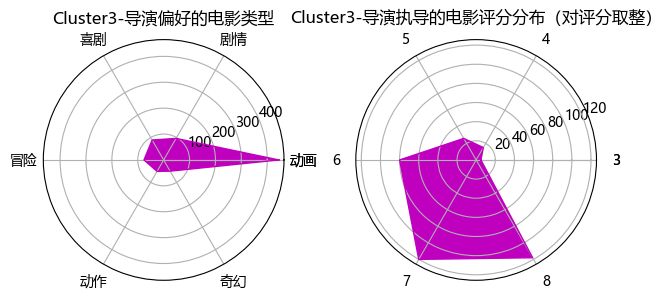

可以看出，Cluster 3中的464部电影几乎全部是动画电影，其他频率较高的类型还有剧情、喜剧、冒险、奇幻等，也与动画相关联。
对照导演名单可以看出，这一类导演混杂中国与外国、东西方的导演，其中日本导演最多，且都是以制作动漫电影出名的导演，与电影特征相一致。
这部分电影的评分集中在6-8分，特别是7-8分之间，与平均水平相比有明显提高，说明（至少在这个数据集中）动画类电影比较出色。 


下面对导演的Cluster 1进行分析：
Cluster 1中的所有导演名单：
['比利·奥古斯特', '亚历山大·阿嘉', '拉加·高斯内尔', '泰勒·海克福德', '亚当·温加德', '马丁·斯科塞斯', '尼古拉斯·斯托勒', '王子逸', '斯科特·德瑞克森', '西娅·夏罗克', '肖恩·麦克纳马拉', '泰伦斯·马力克', '塞德里克·康', '李·杜兰·克里格', '安德烈·艾弗道夫', '汤姆·哈伯', '阿尔伯特·塞拉', '威尔·古勒', '彭浩翔', '安迪·坦纳特', '艾德亚多·桑奇兹', '丹尼·博伊尔', '克里斯蒂安·佩措尔德', '马库斯·邓斯坦', '瑞恩·墨菲', '亚历桑德拉泰雷斯·肯宁', '文森佐·纳塔利', '诺亚·鲍姆巴赫', '马库斯·尼斯佩尔', '亚当梅森', '戴维·布莱尔', '尤金·格林', '小理查德·贝茨', '马克·佩灵顿', 'S·S·拉贾穆里', '迈克尔·霍夫曼', '伯纳德·罗斯', '阿扬·慕克吉', '马克·杨', '莱·拉索扬', '乔安娜·霍格', '德尼·科泰', '李洙成', '马克·阿特金斯', '瑞卡多·米拉尼', '史蒂芬·戴德利', '斯科特·斯皮尔', '罗宁·提姆', '尼克·里昂', '詹姆斯·肯特', '伊沃·冯·霍夫', '托德·海因斯', '法比耶娜·贝尔托', '彼得·休伊特', '刘杰', '罗斯·卡兹', '大卫·米奇欧德', '艾瑞克·英格兰德', '史蒂文·R·蒙若尔', '陈俊彦', '肯尼思·布拉纳', '马库斯·戈勒', '塞巴斯蒂安·古提耶雷兹', '曼斯·马林德', '比约恩·史坦', '安东尼·C·费兰特', '弗雷德·谢皮西', '米夏埃尔·艾斯', '埃里克·布罗斯', '提莫·贝克曼贝托夫', '凯文·史密斯', '帕尼勒·费舍尔·克里斯藤森',

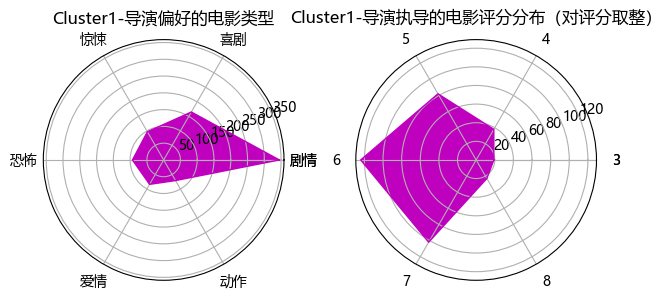

Cluster 1中的导演绝大部分是西方导演，此外还有极少数的日本、韩国等亚洲导演。
从类型分布雷达图中，可以得知以西方人为主导的这部分导演的偏好，585部电影中有超过一半是剧情片，此外喜剧、惊悚、恐怖等题材也比较受这些导演的欢迎。
这部分电影的评分集中在5-7之间，比之前的Cluster 3要差一些，算是平均水平，原因可能是这一类导演只是以地区做了主要的共同特征，并没有按照特定的题材偏好或者评分水平进行分类，所以导演水平自然良莠不齐，最终的结果也比较平均。


In [21]:
# 使用可视化的方法，分析2-3个属于不同类型的导演的特点

print("首先分析导演的Cluster 3：")
indices3 = np.where(labels_directors == 3)[0]

print("Cluster 3中的所有导演名单：")
print([directors_names[i] for i in indices3], '\n')

# 统计Cluster 3中导演所执导的全部电影
movie_list = []
for i in indices3:
    for movie in director_dict[directors_names[i]]:
        movie_list.append(movie)
print("Cluster 3中的电影总数：", len(movie_list))

# 获取Cluster 3中导演的类型GENRES偏好（将全部电影的标签统计起来，取频率最高的6个标签绘制雷达图）
genres = [genre.split(' ') for genre in data.iloc[movie_list]['GENRES']]
genres_flat = [genre for sublist in genres for genre in sublist]
unique_genres = sorted(list(set(genres_flat)))
counts = [genres_flat.count(genre) for genre in unique_genres]
genres_count = {}
for i in range(len(unique_genres)):
    genres_count[unique_genres[i]] = counts[i]
genres_count = sorted(genres_count.items(), key=lambda x:x[1], reverse=True)[:6]

# 雷达图
ax1 = plt.subplot(121, polar=True)
ax2 = plt.subplot(122, polar=True)
name = [item[0] for item in genres_count]
value = [item[1] for item in genres_count]
theta = np.linspace(0,2*np.pi,len(name),endpoint=False)
name = np.concatenate((name,[name[0]]))
theta = np.concatenate((theta,[theta[0]]))
value = np.concatenate((value,[value[0]]))

ax1.set_xticks(theta)
ax1.set_xticklabels(name)
ax1.plot(theta,value,'m-',lw=1)
ax1.fill(theta,value,'m')
ax1.set_title('Cluster3-导演偏好的电影类型')

# 获取Cluster 3中导演所执导电影的DOUBAN_SCORE分布（将全部电影的分数统计起来，忽略评分为0的电影）
scores = [score for score in data.iloc[movie_list]['DOUBAN_SCORE']]
unique_scores = sorted(list(set(scores)))
counts = [scores.count(score) for score in unique_scores]
scores_count = {}
for i in range(len(unique_scores)):
    if int(unique_scores[i]) in scores_count:
        scores_count[int(unique_scores[i])] += counts[i]
    else:
        scores_count[int(unique_scores[i])] = counts[i]
del scores_count[0]
del scores_count[2]
del scores_count[9]

# 雷达图
name = [item for item in scores_count]
value = [scores_count[item] for item in scores_count]
theta = np.linspace(0,2*np.pi,len(name),endpoint=False)
name = np.concatenate((name,[name[0]]))
theta = np.concatenate((theta,[theta[0]]))
value = np.concatenate((value,[value[0]]))
 
ax2.set_xticks(theta)
ax2.set_xticklabels(name)
ax2.plot(theta,value,'m-',lw=1)
ax2.fill(theta,value,'m')
ax2.set_title('Cluster3-导演执导的电影评分分布（对评分取整）')

plt.tight_layout()
plt.show()

print("可以看出，Cluster 3中的464部电影几乎全部是动画电影，其他频率较高的类型还有剧情、喜剧、冒险、奇幻等，也与动画相关联。")
print("对照导演名单可以看出，这一类导演混杂中国与外国、东西方的导演，其中日本导演最多，且都是以制作动漫电影出名的导演，与电影特征相一致。")
print("这部分电影的评分集中在6-8分，特别是7-8分之间，与平均水平相比有明显提高，说明（至少在这个数据集中）动画类电影比较出色。", '\n\n')

print("下面对导演的Cluster 1进行分析：")
indices1 = np.where(labels_directors == 1)[0]

print("Cluster 1中的所有导演名单：")
print([directors_names[i] for i in indices1], '\n')

# 统计Cluster 1中导演所执导的全部电影
movie_list = []
for i in indices1:
    for movie in director_dict[directors_names[i]]:
        movie_list.append(movie)
print("Cluster 1中的电影总数：", len(movie_list))

# 获取Cluster 1中导演的类型GENRES偏好（将全部电影的标签统计起来，取频率最高的6个标签绘制雷达图）
genres = [genre.split(' ') for genre in data.iloc[movie_list]['GENRES']]
genres_flat = [genre for sublist in genres for genre in sublist]
unique_genres = sorted(list(set(genres_flat)))
counts = [genres_flat.count(genre) for genre in unique_genres]
genres_count = {}
for i in range(len(unique_genres)):
    genres_count[unique_genres[i]] = counts[i]
genres_count = sorted(genres_count.items(), key=lambda x:x[1], reverse=True)[:6]

# 雷达图
ax1 = plt.subplot(121, polar=True)
ax2 = plt.subplot(122, polar=True)
name = [item[0] for item in genres_count]
value = [item[1] for item in genres_count]
theta = np.linspace(0,2*np.pi,len(name),endpoint=False)
name = np.concatenate((name,[name[0]]))
theta = np.concatenate((theta,[theta[0]]))
value = np.concatenate((value,[value[0]]))

ax1.set_xticks(theta)
ax1.set_xticklabels(name)
ax1.plot(theta,value,'m-',lw=1)
ax1.fill(theta,value,'m')
ax1.set_title('Cluster1-导演偏好的电影类型')

# 获取Cluster 1中导演所执导电影的DOUBAN_SCORE分布（将全部电影的分数统计起来，忽略评分为0的电影）
scores = [score for score in data.iloc[movie_list]['DOUBAN_SCORE']]
unique_scores = sorted(list(set(scores)))
counts = [scores.count(score) for score in unique_scores]
scores_count = {}
for i in range(len(unique_scores)):
    if int(unique_scores[i]) in scores_count:
        scores_count[int(unique_scores[i])] += counts[i]
    else:
        scores_count[int(unique_scores[i])] = counts[i]
del scores_count[0]
del scores_count[2]
del scores_count[9]

# 雷达图
name = [item for item in scores_count]
value = [scores_count[item] for item in scores_count]
theta = np.linspace(0,2*np.pi,len(name),endpoint=False)
name = np.concatenate((name,[name[0]]))
theta = np.concatenate((theta,[theta[0]]))
value = np.concatenate((value,[value[0]]))
 
ax2.set_xticks(theta)
ax2.set_xticklabels(name)
ax2.plot(theta,value,'m-',lw=1)
ax2.fill(theta,value,'m')
ax2.set_title('Cluster1-导演执导的电影评分分布（对评分取整）')

plt.tight_layout()
plt.show()


print("Cluster 1中的导演绝大部分是西方导演，此外还有极少数的日本、韩国等亚洲导演。")
print("从类型分布雷达图中，可以得知以西方人为主导的这部分导演的偏好，585部电影中有超过一半是剧情片，此外喜剧、惊悚、恐怖等题材也比较受这些导演的欢迎。")
print("这部分电影的评分集中在5-7之间，比之前的Cluster 3要差一些，算是平均水平，原因可能是这一类导演只是以地区做了主要的共同特征，\
并没有按照特定的题材偏好或者评分水平进行分类，所以导演水平自然良莠不齐，最终的结果也比较平均。")

首先分析演员的Cluster 2：
Cluster 2中的前200位演员名单：
['寺岛忍', '浅野忠信', '渡边谦', '饭丰万理江', '忍成修吾', '谷村美月', '染谷将太', '绫濑遥', '西岛秀俊', '成田凌', '山田凉介', '芳根京子', '莲佛美沙子', '妻夫木聪', '菊地凛子', '大泽隆夫', '贺来贤人', '广濑爱丽丝', '岩田刚典', '高岛政宏', '芦名星', '玉城蒂娜', '余贵美子', '三浦友和', '中村优子', '池田纯矢', '市道真央', '夏帆', '苍井优', '古关安广', '泷正则', '大仓孝二', '佐藤健', '柳乐优弥', '桥本爱', '岩城滉一', '千叶雄大', '滨边美波', '中井贵一', '佐佐木藏之介', '广末凉子', '广濑铃', '堤真一', '吉泽亮', '高畑充希', '山崎贤人', '斋藤工', '松隆子', '福山雅治', '神木隆之介', '菅田将晖', '小松菜奈', '荣仓奈奈', '山本美月', '二阶堂富美', '高杉真宙', '松重丰', '前野朋哉', '竹中直人', '柄本佑', '村上虹郎', '森山未来', '前田吟', '吉冈秀隆', '桥爪功', '小林稔侍', '长泽雅美', '东出昌大', '小日向文世', '竹内结子', '三浦春马', '江口洋介', '小栗旬', '柾木玲弥', '大杉涟', '浅川梨奈', '秋山莉奈', '樱田通', '市原隼人', '中村友理', '津田宽治', '五十岚信次郎', '池松壮亮', '村上淳', '西田尚美', '佐野史郎', '永濑正敏', '门胁麦', '松浦祐也', '筱原友希子', '槙田雄司', '吹越满', '奥田瑛二', '福田麻由子', '本田翼', '平泉成', '松山研一', '堺雅人', '田中圭', '吉田钢太郎', '林遣都', '内田理央', '真岛秀和', '大塚宁宁', '志尊淳', '泽村一树', '前田敦子', '仲野太贺', '户田惠梨香', '佐藤浩市', '北村有起哉', '中村伦也', '矢本悠马', '塚地武雅', '池田铁洋', '古川雄辉', '柄本时生', '松坂桃李', '阿部宽', '安田显', '和田聪宏', '藤冈靛', '井浦

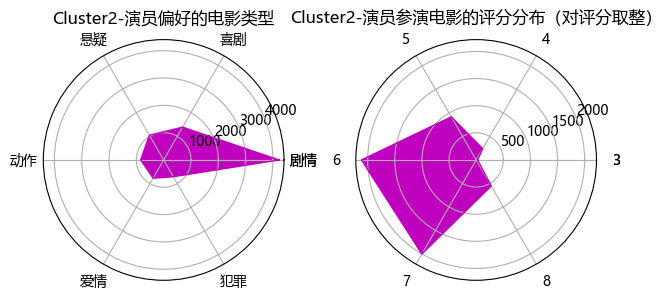

可以看出，Cluster 2中的演员全部为日本演员，偏好参演的电影类型有剧情、喜剧、悬疑、动作等
这部分电影的评分集中在6-7分，稍好于平均水平。 


下面对演员的Cluster 4进行分析：
Cluster 4中的前200位演员名单：
['王博', '王姬', '沈丹萍', '吴孟达', '曾志伟', '杜海涛', '王丽坤', '舒淇', '佟大为', '姜武', '夏雨', '刘德华', '潘粤明', '托尼·贾', '徐峥', '张静初', '林依晨', '汤姆·赫兰德', '阿萨·巴特菲尔德', '高圆圆', '姚星彤', '陈观泰', '章子怡', '胡明', '吴京', '刘涛', '张嘉译', '邹兆龙', '黄一飞', '张亮', '李易祥', '李菁', '王德顺', '刘仪伟', '赵英俊', '赵薇', '陈冲', '谢霆锋', '吴彦祖', '李灿森', '古天乐', '刘烨', '成龙', '范冰冰', '梁朝伟', '萨姆·赖利', '何塞·科罗纳多', '汤唯', '张涵予', '王婷', '宋洋', '葛优', '王学兵', '张榕容', '罗翔', '郑伊健', '王祖蓝', '凡妮莎·柯比', '沈腾', '董立范', '王宝强', '张子枫', '高捷', '景甜', '刘嘉玲', '包贝尔', '李成敏', '许君聪', '廖蔚蔚', '吴亦凡', '陈伟霆', '郭采洁', '山姆·克拉弗林', '郑恺', '李晨', '张钧甯', '李梦', '李光洁', '金世佳', '刘陆', '李勤勤', '唐文龙', '苑琼丹', '魏小欢', '余少群', '多布杰', '赵毅', '周浩东', '吴君如', '周杰伦', '王珞丹', '欧豪', '甄子丹', '李连杰', '郑佩佩', '卡琳娜·卡普尔', '矢野浩二', '黄海冰', '曾江', '颜卓灵', '蔡瀚亿', '陈小春', '谢天华', '保剑锋', '余男', '黄奕', '闫妮', '斯琴高娃', '陈威旭', '何超仪', '黄渤', '郑秀文', '王双宝', '杨子姗', '任达华', '孙红雷', '谢依霖', '马丽', '黄小蕾', '黄晓明', '张学友', '王学圻', '吴毅将', '刘洋', '张震', '春夏', '马思纯', 

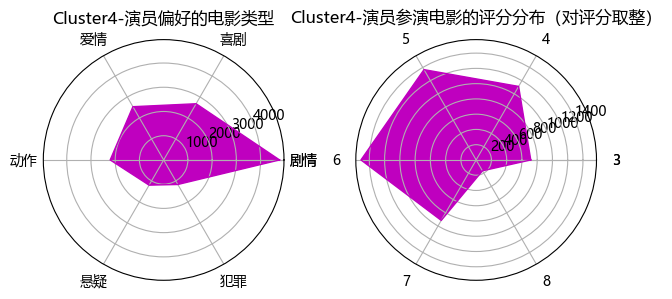

可以看出，Cluster 4中的演员以我国演员为主，包括了内地和港澳台的各知名演员。
有趣的是，我国演员参演电影的类型偏好和上面Cluster 2中的日本演员高度相似，都是剧情、喜剧、动作、爱情等，然而评分却集中在4-6分之间，明显要低于Cluster 2，这说明我国电影在同样题材的情况下，和日本电影的水平相比还有一定的差距。 




In [22]:
# 使用可视化的方法，分析2-3个属于不同类型的演员的特点
print("首先分析演员的Cluster 2：")
indices2 = np.where(labels_actors == 2)[0]

print("Cluster 2中的前200位演员名单：")
print([actors_names[i] for i in indices2][:200], '\n')

# 统计Cluster 2中演员所参演的全部电影
movie_list = []
for i in indices2:
    for movie in actor_dict[actors_names[i]]:
        movie_list.append(movie)
print("Cluster 2中的电影总数：", len(movie_list))

# 获取Cluster 2中演员出演电影的类型GENRES偏好（将全部电影的标签统计起来，取频率最高的6个标签绘制雷达图）
genres = [genre.split(' ') for genre in data.iloc[movie_list]['GENRES']]
genres_flat = [genre for sublist in genres for genre in sublist]
unique_genres = sorted(list(set(genres_flat)))
counts = [genres_flat.count(genre) for genre in unique_genres]
genres_count = {}
for i in range(len(unique_genres)):
    genres_count[unique_genres[i]] = counts[i]
genres_count = sorted(genres_count.items(), key=lambda x:x[1], reverse=True)[:6]

# 雷达图
ax1 = plt.subplot(121, polar=True)
ax2 = plt.subplot(122, polar=True)
name = [item[0] for item in genres_count]
value = [item[1] for item in genres_count]
theta = np.linspace(0,2*np.pi,len(name),endpoint=False)
name = np.concatenate((name,[name[0]]))
theta = np.concatenate((theta,[theta[0]]))
value = np.concatenate((value,[value[0]]))

ax1.set_xticks(theta)
ax1.set_xticklabels(name)
ax1.plot(theta,value,'m-',lw=1)
ax1.fill(theta,value,'m')
ax1.set_title('Cluster2-演员偏好的电影类型')

# 获取Cluster 2中演员所参演电影的DOUBAN_SCORE分布（将全部电影的分数统计起来，忽略评分为0的电影）
scores = [score for score in data.iloc[movie_list]['DOUBAN_SCORE']]
unique_scores = sorted(list(set(scores)))
counts = [scores.count(score) for score in unique_scores]
scores_count = {}
for i in range(len(unique_scores)):
    if int(unique_scores[i]) in scores_count:
        scores_count[int(unique_scores[i])] += counts[i]
    else:
        scores_count[int(unique_scores[i])] = counts[i]
del scores_count[0]
del scores_count[2]
del scores_count[9]

# 雷达图
name = [item for item in scores_count]
value = [scores_count[item] for item in scores_count]
theta = np.linspace(0,2*np.pi,len(name),endpoint=False)
name = np.concatenate((name,[name[0]]))
theta = np.concatenate((theta,[theta[0]]))
value = np.concatenate((value,[value[0]]))
 
ax2.set_xticks(theta)
ax2.set_xticklabels(name)
ax2.plot(theta,value,'m-',lw=1)
ax2.fill(theta,value,'m')
ax2.set_title('Cluster2-演员参演电影的评分分布（对评分取整）')

plt.tight_layout()
plt.show()

print("可以看出，Cluster 2中的演员全部为日本演员，偏好参演的电影类型有剧情、喜剧、悬疑、动作等")
print("这部分电影的评分集中在6-7分，稍好于平均水平。", '\n\n')

print("下面对演员的Cluster 4进行分析：")
indices4 = np.where(labels_actors == 4)[0]

print("Cluster 4中的前200位演员名单：")
print([actors_names[i] for i in indices4][:200], '\n')

# 统计Cluster 4中演员所参演的全部电影
movie_list = []
for i in indices4:
    for movie in actor_dict[actors_names[i]]:
        movie_list.append(movie)
print("Cluster 4中的电影总数：", len(movie_list))

# 获取Cluster 4演员出演电影的类型GENRES偏好（将全部电影的标签统计起来，取频率最高的6个标签绘制雷达图）
genres = [genre.split(' ') for genre in data.iloc[movie_list]['GENRES']]
genres_flat = [genre for sublist in genres for genre in sublist]
unique_genres = sorted(list(set(genres_flat)))
counts = [genres_flat.count(genre) for genre in unique_genres]
genres_count = {}
for i in range(len(unique_genres)):
    genres_count[unique_genres[i]] = counts[i]
genres_count = sorted(genres_count.items(), key=lambda x:x[1], reverse=True)[:6]

# 雷达图
ax1 = plt.subplot(121, polar=True)
ax2 = plt.subplot(122, polar=True)
name = [item[0] for item in genres_count]
value = [item[1] for item in genres_count]
theta = np.linspace(0,2*np.pi,len(name),endpoint=False)
name = np.concatenate((name,[name[0]]))
theta = np.concatenate((theta,[theta[0]]))
value = np.concatenate((value,[value[0]]))

ax1.set_xticks(theta)
ax1.set_xticklabels(name)
ax1.plot(theta,value,'m-',lw=1)
ax1.fill(theta,value,'m')
ax1.set_title('Cluster4-演员偏好的电影类型')

# 获取Cluster 4中演员所参演电影的DOUBAN_SCORE分布（将全部电影的分数统计起来，忽略评分为0的电影）
scores = [score for score in data.iloc[movie_list]['DOUBAN_SCORE']]
unique_scores = sorted(list(set(scores)))
counts = [scores.count(score) for score in unique_scores]
scores_count = {}
for i in range(len(unique_scores)):
    if int(unique_scores[i]) in scores_count:
        scores_count[int(unique_scores[i])] += counts[i]
    else:
        scores_count[int(unique_scores[i])] = counts[i]
del scores_count[0]
del scores_count[2]
del scores_count[9]

# 雷达图
name = [item for item in scores_count]
value = [scores_count[item] for item in scores_count]
theta = np.linspace(0,2*np.pi,len(name),endpoint=False)
name = np.concatenate((name,[name[0]]))
theta = np.concatenate((theta,[theta[0]]))
value = np.concatenate((value,[value[0]]))
 
ax2.set_xticks(theta)
ax2.set_xticklabels(name)
ax2.plot(theta,value,'m-',lw=1)
ax2.fill(theta,value,'m')
ax2.set_title('Cluster4-演员参演电影的评分分布（对评分取整）')

plt.tight_layout()
plt.show()

print("可以看出，Cluster 4中的演员以我国演员为主，包括了内地和港澳台的各知名演员。")
print("有趣的是，我国演员参演电影的类型偏好和上面Cluster 2中的日本演员高度相似，都是剧情、喜剧、动作、爱情等，\
然而评分却集中在4-6分之间，明显要低于Cluster 2，这说明我国电影在同样题材的情况下，和日本电影的水平相比还有一定的差距。", '\n\n')